In [1]:
%matplotlib inline

import ROOT, sys, os
from ROOT import std

from larcv import larcv
from larlite import larlite as ll
from larlite import larutil as lu

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib.patches as patches

from ROOT import geo2d,cv
from ROOT.cv import Point_ as Vector
DTYPE='float'

import root_numpy as rn
import pandas as pd

geoh=lu.GeometryHelper.GetME()
geo=lu.Geometry.GetME()
larp=lu.LArProperties.GetME()
pygeo = geo2d.PyDraw()

In [2]:
reco_df = pd.DataFrame(rn.root2rec("../reco_ana.root",treename='LArbysImageTree'))
mc_df   = pd.DataFrame(rn.root2rec("../mc_ana.root",treename='mctree'))

/Library/Python/2.7/site-packages/root_numpy/_tree.py:248: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
/Library/Python/2.7/site-packages/root_numpy/_tree.py:248: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)


In [3]:
iom=larcv.IOManager(larcv.IOManager.kBOTH)        
iom.reset()
iom.set_verbosity(0)                                                                          
iom.add_in_file("/Users/vgenty/Desktop/out_0000_0099.root")
iom.set_out_file("/tmp/trash.root")
iom.initialize()

larbysimg=larcv.LArbysImage()
cfg=larcv.CreatePSetFromFile("empty.fcl","LArbysImage")
larbysimg.configure(cfg)
larbysimg.initialize()

entry:  254 ... iz:  0
run                                                                4
subrun                                                          1457
event                                                          29136
n_mip_ctors_v                                              [1, 1, 1]
n_hip_ctors_v                                              [1, 1, 0]
n_vtx3d                                                            1
vtx3d_x_v                                            [178.900656607]
vtx3d_y_v                                           [-47.7872302331]
vtx3d_z_v                                                   [920.05]
vtx2d_x_vv           [[263.991210938, 263.991210938, 263.991210938]]
vtx2d_y_vv                                   [[254.0, 345.5, 303.5]]
circle_vtx_x_vv      [[263.991210938, 263.844696045, 265.211334229]]
circle_vtx_y_vv              [[254.0, 344.900878906, 303.766387939]]
num_planes_v                                                     [2]
num_cluster

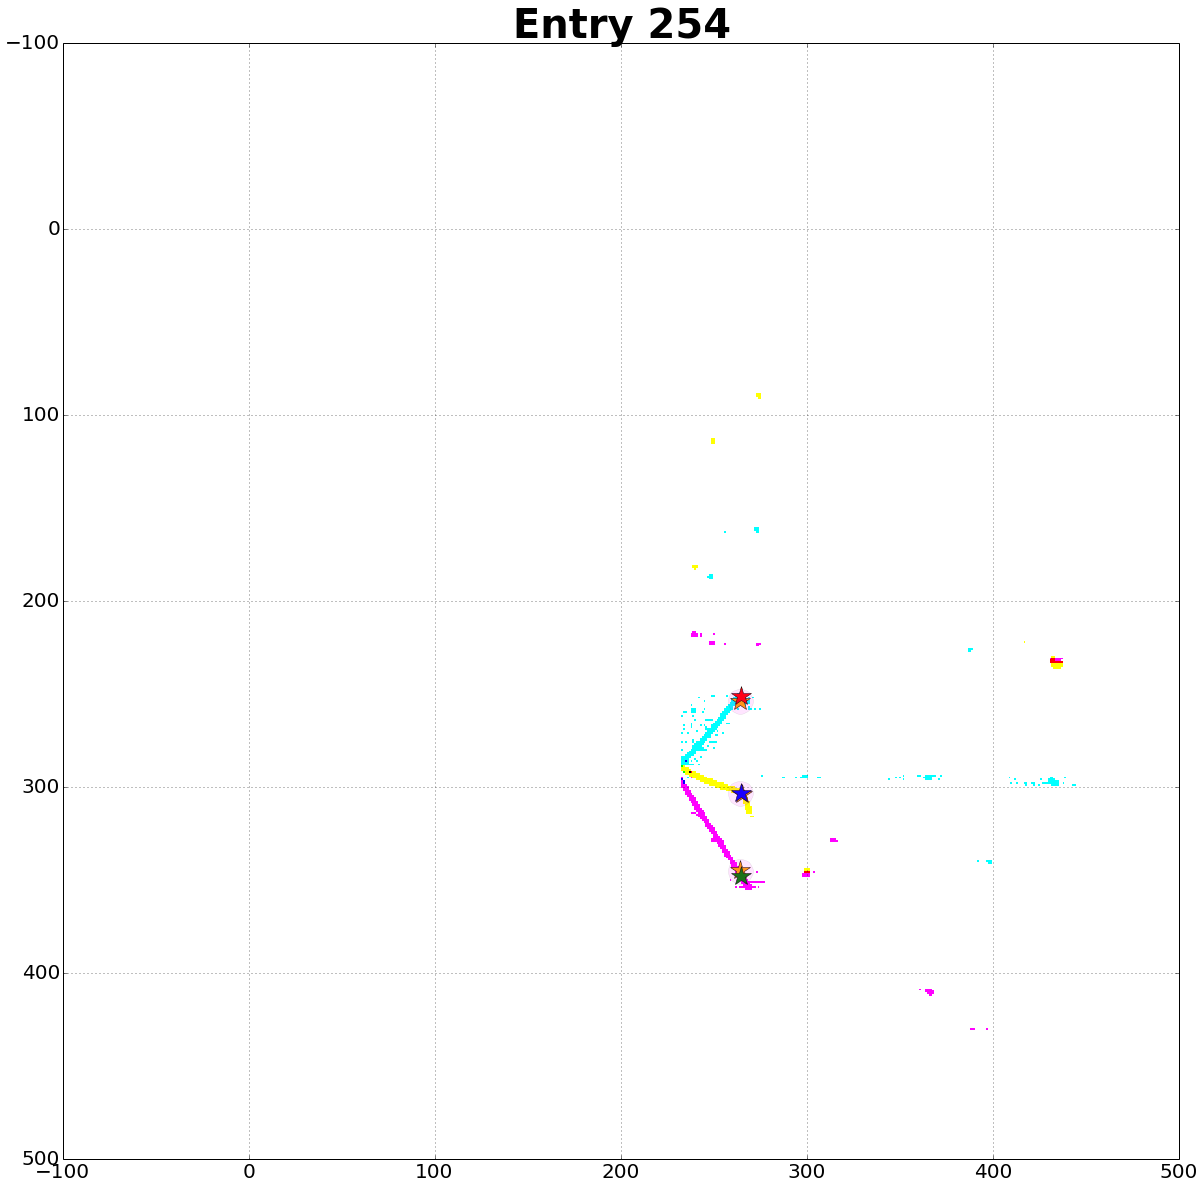

In [84]:
for iz,entry in enumerate([254]):#mc_reco_ix_v:
    iom.read_entry(entry)
    larbysimg.process(iom)
    mgr=larbysimg.Manager()
    
    img_v = []

    fig,ax=plt.subplots(figsize=(20,20))
    maxx=0;minx=9999
    maxy=0;miny=9999
    plane=0

   

    sel_df=reco_df.iloc[entry]
    caca_img=np.zeros((485, 485,3))
    cc=-1
    for mat in mgr.InputImages():
        cc+=1

        img_v.append(pygeo.image(mat))
        shape_img=np.where(img_v[plane]>1.5,1.0,0.0).astype(np.uint8)

        plane+=1

        nz_pixels=np.where(shape_img>0.0)
        
        maxx=np.maximum(maxx,np.max(nz_pixels[1])+100)
        minx=np.minimum(minx,np.min(nz_pixels[1])-100)

        maxy=np.maximum(maxy,np.max(nz_pixels[0])+100)
        miny=np.minimum(miny,np.min(nz_pixels[0])-100)

        caca_img[:,:,cc]=shape_img
        
    caca_img=np.where(caca_img>0.0,1.0,255)
    caca_img=caca_img.astype(np.uint8)
    plt.imshow(caca_img,interpolation='none')
    
    for cv_x_v,cv_y_v in zip(sel_df.circle_vtx_x_vv,
                             sel_df.circle_vtx_y_vv):

        for x,y in zip(cv_x_v,cv_y_v):
            plt.plot(x,y,'*',color='orange',markersize=20)
        
    w_v=mc_df.iloc[entry].vtx2d_w
    t_v=mc_df.iloc[entry].vtx2d_t
    ic=-1
    colors=['red','green','blue']
           
    for w,t in zip(w_v,t_v):
            ic+=1
            plt.plot(t,w,'*',color=colors[ic],markersize=20)
    
    for vtx2_x_v,vtx2_y_v in zip(sel_df.vtx2d_x_vv,
                                 sel_df.vtx2d_y_vv):

        for x,y in zip(vtx2_x_v,vtx2_y_v):
            plt.plot(x,y,'o',color='magenta',markersize=25,alpha=0.1)
            
    ax.set_title("Entry {}".format(entry),fontweight='bold',fontsize=40)
    #plt.savefig("reco_%04d.png"%entry)
    plt.grid()
    colors=['cyan---: ','magenta: ','yellow-: ']
    print "entry: ",entry,"... iz: ",iz
    print reco_df.ix[entry]
    #for ii in xrange(3):
    #    print colors[ii],p_[iz][ii]
    plt.show()


In [26]:
#reco_df_copy will have out analysis cuts built in
reco_df_copy = reco_df.copy()

cuts_v=[]
cuts_v.append('n_vtx3d>0')

for cut in cuts_v:
    reco_df_copy = reco_df_copy.query(cut)

#filter vertices from, only care about the events that have
#vertex estimated from 3 planes
reco_df_copy = reco_df_copy[reco_df_copy['num_planes_v'].apply(lambda x : np.where(x==3)[0].size)>0]

#cut on the pixel frac
pxfrac=0.9
def pixels(x):
    y=np.hstack(x)
    return np.where(y>pxfrac)[0].size

reco_df_copy=reco_df_copy[reco_df_copy['num_pixel_frac_vv'].apply(pixels) > 0]

In [5]:
mclist = np.array([8, 9, 23, 29, 42, 52, 55, 64, 65, 85, 93, 104, 107, 114, 119, 125, 139, 142, 145, 150, 165, 167, 175, 183, 204, 205, 211, 219, 226, 228, 229, 254, 255, 264, 266])

In [6]:
rui_df=reco_df.ix[mclist]

In [7]:
print mclist.size
vic_df=rui_df[rui_df['num_planes_v'].apply(lambda x : x.size)>0]
print vic_df.index.size
print rui_df[rui_df['num_planes_v'].apply(lambda x : np.where(x==3)[0].size)>0].index.size

35
28
21


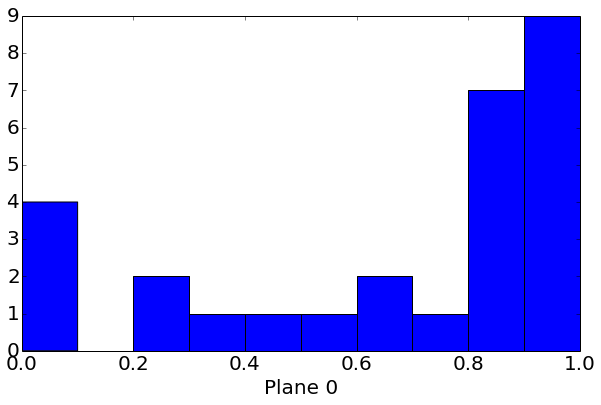

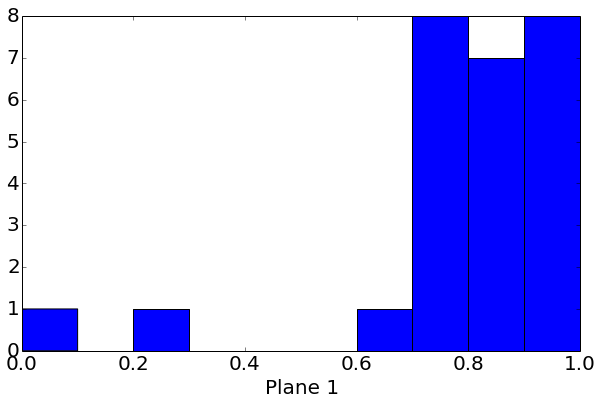

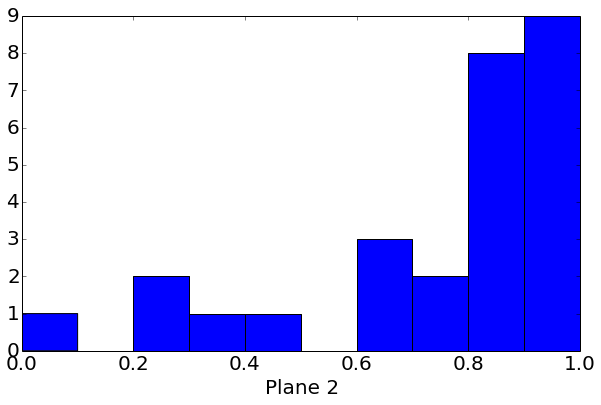

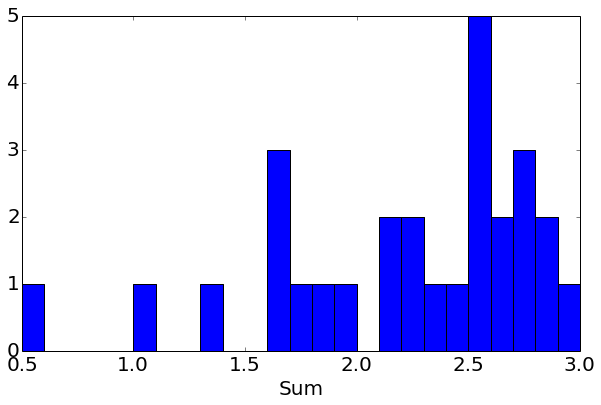

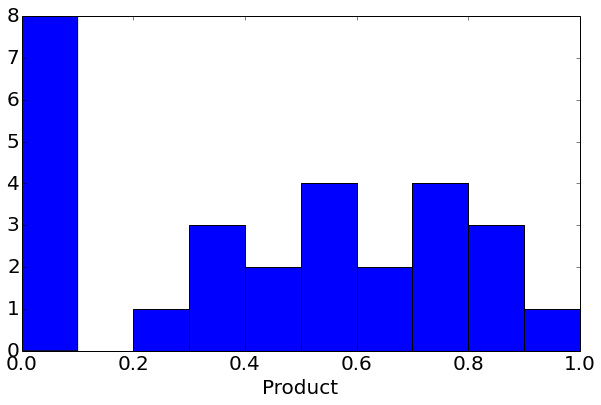

In [65]:
p_=[]
mc_idx_c=[]
for ix,row in vic_df.iterrows():
    s=0
    idx=0
    for ix,r in enumerate(row['num_pixel_frac_vv']):
        if r.sum() > s:
            s=r.sum()
            idx=ix
    if s==0:
        print row
    mc_idx_c.append(idx)
    p_.append(row['num_pixel_frac_vv'][ix])
p_=np.array(p_)
matplotlib.rcParams['font.size']=20
for i in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(p_[:,i],bins=np.arange(0,1+0.1,0.1))
    ax.set_xlabel("Plane {}".format(i))
    plt.show()

fig,ax=plt.subplots(figsize=(10,6))
ax.hist(p_.sum(axis=1),bins=np.arange(0,3+0.1,0.1))
ax.set_xlabel("Sum")
plt.show()
fig,ax=plt.subplots(figsize=(10,6))
ppp=p_[:,0]*p_[:,1]*p_[:,2]
ax.hist(ppp,bins=np.arange(0,1+0.1,0.1))

ax.set_xlim(0,1.0)
ax.set_xlabel("Product")
plt.show()

In [76]:
print p_.shape
print ppp.size
np.where(ppp==0)
vic_df.iloc[26]

(28, 3)
28


run                                                                4
subrun                                                          1457
event                                                          29136
n_mip_ctors_v                                              [1, 1, 1]
n_hip_ctors_v                                              [1, 1, 0]
n_vtx3d                                                            1
vtx3d_x_v                                            [178.900656607]
vtx3d_y_v                                           [-47.7872302331]
vtx3d_z_v                                                   [920.05]
vtx2d_x_vv           [[263.991210938, 263.991210938, 263.991210938]]
vtx2d_y_vv                                   [[254.0, 345.5, 303.5]]
circle_vtx_x_vv      [[263.991210938, 263.844696045, 265.211334229]]
circle_vtx_y_vv              [[254.0, 344.900878906, 303.766387939]]
num_planes_v                                                     [2]
num_clusters_vv                   

In [ ]:
mc_df_copy = mc_df.copy()
mc_df_copy=mc_df_copy[mc_df_copy.daughterPdg_v.apply(lambda x : x.size)==2]
print mc_df_copy.index.size

In [ ]:
reco_idx

In [ ]:
mc_df_copy.index

In [ ]:
reco_df.ix[175]

In [ ]:
ex=np.array([4, 8, 9, 10, 12, 13, 23, 33, 34, 40, 41, 45, 52, 53, 63, 65, 71, 79, 86, 88, 93, 95, 97, 103, 107, 114, 123, 125, 127, 132, 140, 142, 143, 145, 150, 152, 156, 159, 175, 178, 184, 185, 186, 191, 195, 200, 204, 205, 211, 215, 216, 219, 223, 225, 226, 228, 229, 230, 242, 253, 266, 270])

np3_v=reco_df.ix[ex].num_planes_v.apply(lambda x : np.where(x==3)[0][0])
print np3_v.size

In [ ]:
dw_v=[]
dt_v=[]
mc_reco_ix_v=[]

#for mc_ix,mc_row in mc_df_copy.iterrows():
#   if mc_ix not in reco_idx.values:
#        continue
print ex.size
for mc_ix in ex:   
    mc_row=mc_df.ix[mc_ix]
    mc_reco_ix_v.append(mc_ix)
    reco_row = reco_df.ix[mc_ix]
    mc_w   = mc_row.vtx2d_w
    mc_t   = mc_row.vtx2d_t
    reco_t = reco_row.circle_vtx_x_vv[np3_v.ix[mc_ix]]
    reco_w = reco_row.circle_vtx_y_vv[np3_v.ix[mc_ix]]
    dw = mc_w - reco_w
    dt = mc_t - reco_t
    dw_v.append(dw)
    dt_v.append(dt)
    
mc_reco_ix_v=np.array(mc_reco_ix_v)

dw_v = np.array(dw_v)
dt_v = np.array(dt_v)  
print dt_v.size,dw_v.size

In [ ]:
#mc_df.query('energyDeposit>=100 & energyDeposit<=500').index.values.simc_df.parentPz.values
Px2= np.power(mc_df.parentPx.values,2)
Py2= np.power(mc_df.parentPy.values,2)
Pz2= np.power(mc_df.parentPz.values,2)

initE = np.sqrt(Px2+Py2+Pz2)
containfrac=mc_df.energyDeposit.values/initE
np.where(containfrac<0.2)
a,_,_=plt.hist(containfrac,bins=np.arange(0,1.0+0.1,0.1))
print a,a.sum()
plt.grid()
plt.show()

In [ ]:
r=[]
pdg2mass={}
pdg2mass[13]=0#105
pdg2mass[2212]=938
pdg2mass[11]=0#0.5

for ix,row in mc_df.iterrows():
    init_sum=0
    dep_sum=0
    for pdg,e in zip(row.daughterPdg_v,
                     row.daughterEnergyInit_v):
        init_sum += e-pdg2mass[pdg]
        #print "init:",pdg,e
    for pdg,e in zip(row.daughterPdg_v,
                     row.daughterEnergyDep_v):
        dep_sum += e
        #print "dep:",pdg,e
    r.append(dep_sum / init_sum)
    
r=np.array(r)
print np.where(r>0.9)[0].size
a,_,_=plt.hist(r,bins=np.arange(0,1.0+0.025,0.025))
print a.sum()

In [ ]:
matplotlib.rcParams['font.size']=20
matplotlib.rcParams['font.family']='serif'

fig,ax=plt.subplots(figsize=(10,6))
for i in xrange(3):
    ax.hist(dw_v[:,i],
            label='Plane {}'.format(i),
            bins=np.arange(-80,80+2,2),
            alpha=0.5)
ax.set_xlabel("(MC - Reco) Wire [pixel]",fontweight='bold')
ax.set_ylim(0,30)
ax.set_xlim(-100,100)
ax.legend()
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))
for i in xrange(3):
    ax.hist(dt_v[:,i],
            label='Plane {}'.format(i),
            bins=np.arange(-80,80+2,2),
            alpha=0.5)
ax.set_xlabel("(MC - Reco) Time [pixel]",fontweight='bold')
ax.set_ylim(0,30)
ax.set_xlim(-100,100)
ax.legend()
plt.grid()
plt.show()


for i in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(np.sqrt(np.power(dw_v[:,i],2)+np.power(dt_v[:,i],2)),
            label='Plane {}'.format(i),
            bins=np.arange(0,100+1,1),
            alpha=0.5,lw=2)
    ax.set_xlabel("Dist MC Reco Vtx [pixel]",fontweight='bold')
    ax.set_ylim(0,30)
    ax.set_xlim(0,100)
    ax.legend()
    plt.grid()
    plt.show()


In [ ]:
proton_df=mc_df[mc_df['daughterPdg_v'].apply(lambda x : 2212 in x)]
oneproton_df=proton_df[proton_df['daughterPdg_v'].apply(lambda x : x.size==2)]

In [ ]:
plt.hist(oneproton_df.daughterEnergyDep_v.str[1],bins=np.arange(0,350+25,25))
plt.grid()
plt.show()
fig,ax=plt.subplots(figsize=(10,6))
plt.hist2d(oneproton_df.daughterEnergyDep_v.str[1].values,
          oneproton_df.daughterLength_vv.str[2].str[1].values,
          bins=(np.arange(0,350+20,20),np.arange(0,350+20,20)))
plt.colorbar()
ax=plt.gca()
ax.set_xlabel("Proton Energy Dep",fontweight='bold')
ax.set_ylabel("Estimated Proton\n Length in Plane 2 [pixels]",fontweight='bold')
plt.show()

In [ ]:
#calculate the MC angular distribution

for plane in [0,1,2]:

    p1start_x_v = oneproton_df.daughter2DStartX_vv.str[plane].str[0]
    p1start_y_v = oneproton_df.daughter2DStartY_vv.str[plane].str[0]
    p1end_x_v   = oneproton_df.daughter2DEndX_vv.str[plane].str[0]
    p1end_y_v   = oneproton_df.daughter2DEndY_vv.str[plane].str[0]

    p2start_x_v = oneproton_df.daughter2DStartX_vv.str[plane].str[1]
    p2start_y_v = oneproton_df.daughter2DStartY_vv.str[plane].str[1]
    p2end_x_v   = oneproton_df.daughter2DEndX_vv.str[plane].str[1]
    p2end_y_v   = oneproton_df.daughter2DEndY_vv.str[plane].str[1]


    p1start_v = np.vstack((p1start_x_v,
                           p1start_y_v)).T
    
    p1end_v = np.vstack((p1end_x_v,
                         p1end_y_v)).T
    
    p2start_v = np.vstack((p2start_x_v,
                           p2start_y_v)).T
    
    p2end_v = np.vstack((p2end_x_v,
                         p2end_y_v)).T

    p1dir_v=p1end_v-p1start_v;
    p2dir_v=p2end_v-p2start_v;

    numerator=(p1dir_v*p2dir_v).sum(axis=1)
    denominator=np.sqrt(np.power(p1dir_v,2.0).sum(axis=1))*np.sqrt(np.power(p2dir_v,2.0).sum(axis=1))
    costheta=numerator/denominator

    fig,ax=plt.subplots(figsize=(10,6))
    print costheta[30]
    ax.hist(costheta,bins=np.arange(-1,1+0.1,0.1))
    ax.set_xlabel("cos(theta) Plane {} [deg]".format(plane),fontweight='bold')
    ax.set_xlim(-1,1)
    plt.grid()
    plt.show()

In [ ]:
print p1dir_v[0],p2dir_v[0]
print p1dir_v[0]*p2dir_v[0]
print (p1dir_v*p2dir_v).sum(axis=1)[0]
print np.sqrt(np.power(p1dir_v,2.0).sum(axis=1))[0],np.sqrt(np.power(p2dir_v,2.0).sum(axis=1))[0]

In [ ]:
print np.where((costheta<-0.9))
print np.where((costheta>0.9))

In [ ]:
oneproton_df.iloc[30]

In [ ]:
#calculate the MC angular distribution

for plane in [2]:

    p1start_x_v = oneproton_df.daughter2DStartX_vv.str[plane].str[1]
    p1start_y_v = oneproton_df.daughter2DStartY_vv.str[plane].str[1]
    p1end_x_v   = oneproton_df.daughter2DEndX_vv.str[plane].str[1]
    p1end_y_v   = oneproton_df.daughter2DEndY_vv.str[plane].str[1]


    p1start_v = np.vstack((p1start_x_v,
                           p1start_y_v)).T
    
    p1end_v = np.vstack((p1end_x_v,
                         p1end_y_v)).T
    
    p1dir_v=p1end_v-p1start_v;
    
    xx=p1dir_v[:,0]
    yy=p1dir_v[:,1]
    
    angle=xx/(np.sqrt(np.power(xx,2)+np.power(yy,2)))
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(angle,bins=np.arange(-1,1+0.1,0.1))
    ax.set_xlabel("proton cos(theta) Plane {}".format(plane),fontweight='bold')
    ax.set_xlim(-1,1)
    plt.grid()
    plt.show()

In [ ]:
px=oneproton_df.daughterPx_v.str[1].values
py=oneproton_df.daughterPy_v.str[1].values
pz=oneproton_df.daughterPz_v.str[1].values

In [ ]:
plt.hist(pz/np.sqrt(px*px+pz*pz),np.arange(-1,1+0.1,0.1))
ax=plt.gca()
ax.set_xlabel("pz/sqrt(pz^2+px^2)")
plt.grid()
plt.show()

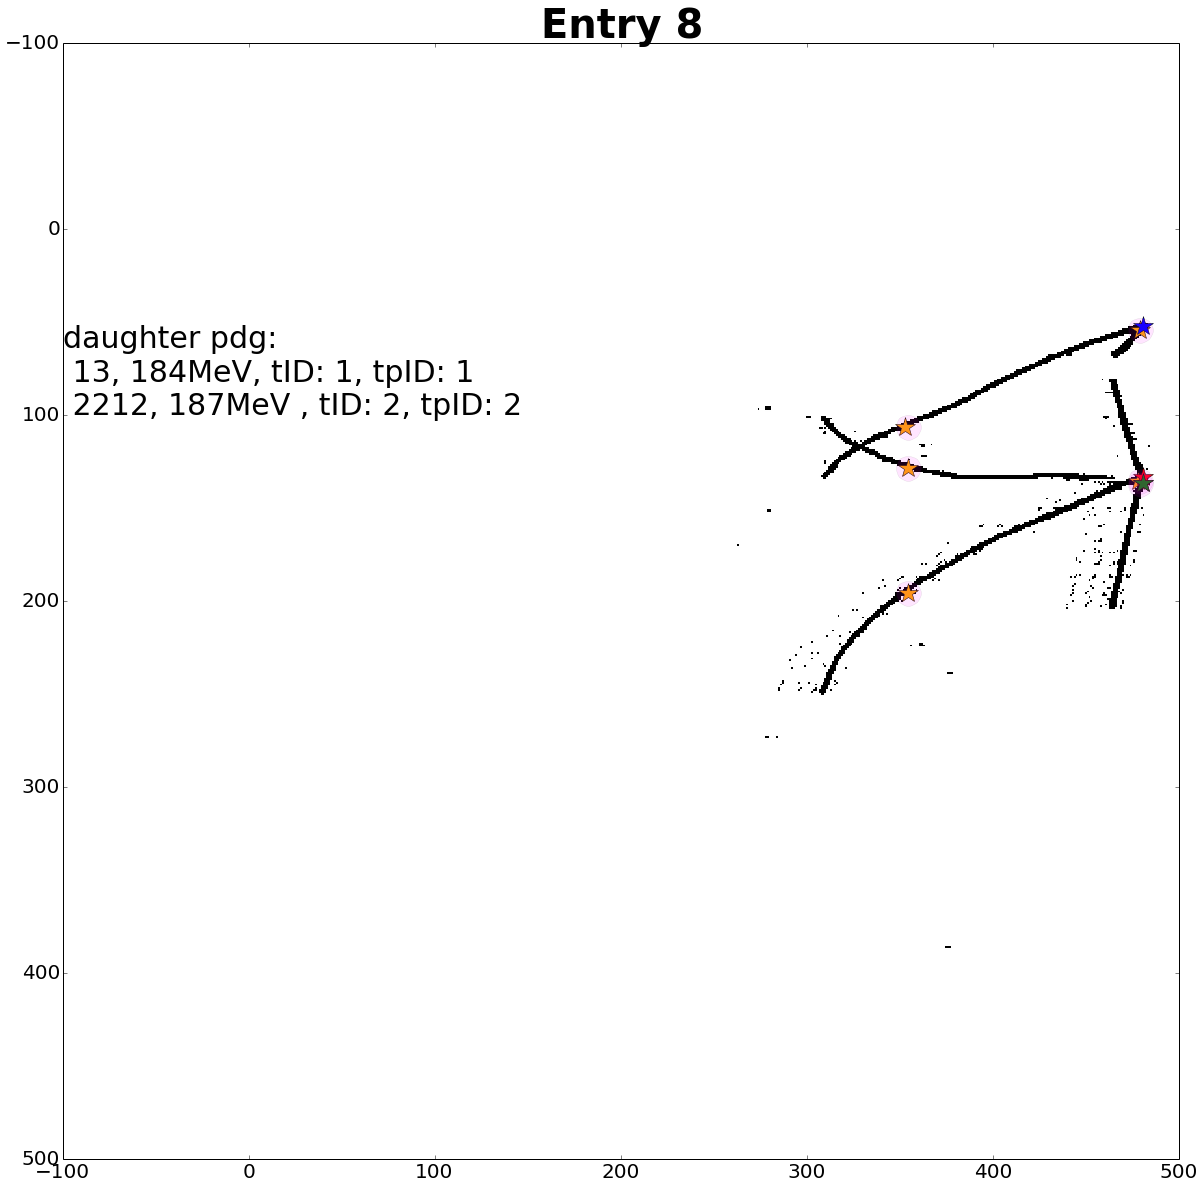

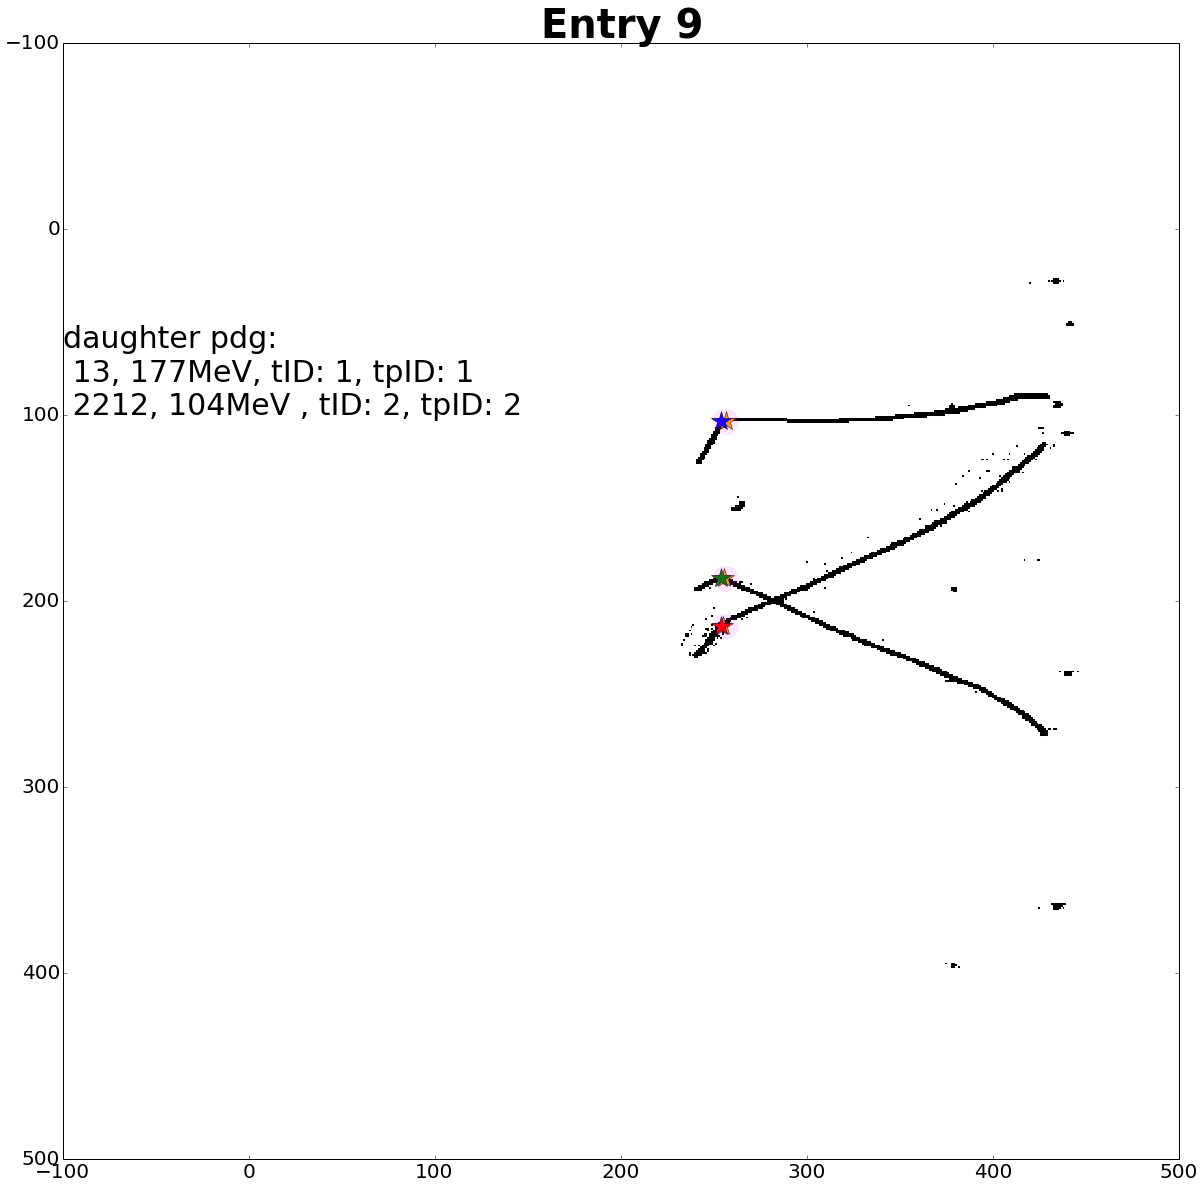

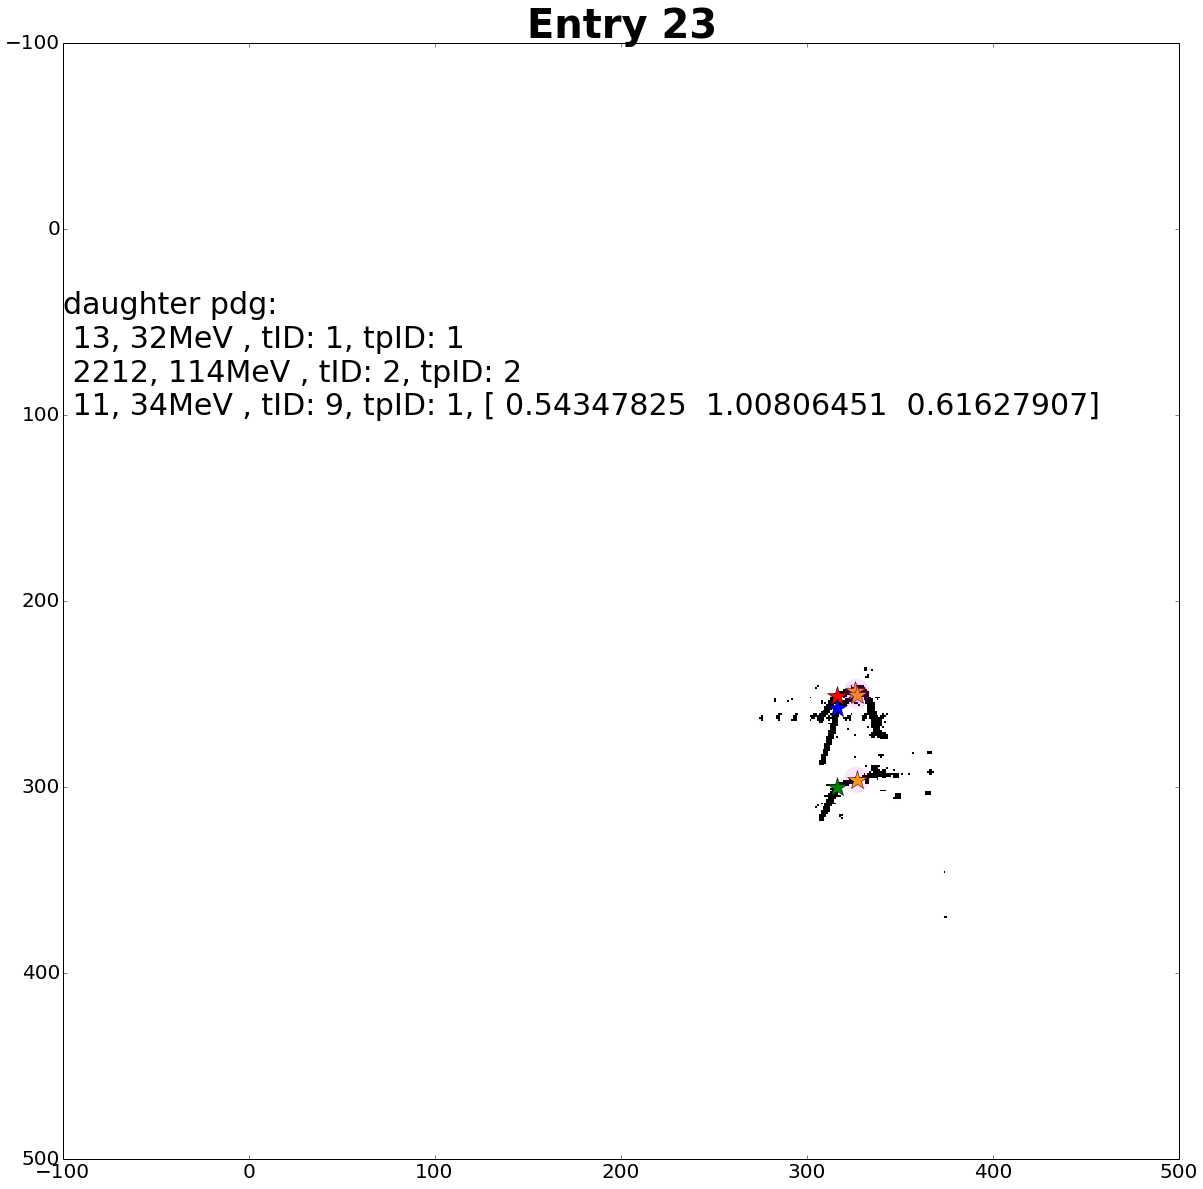

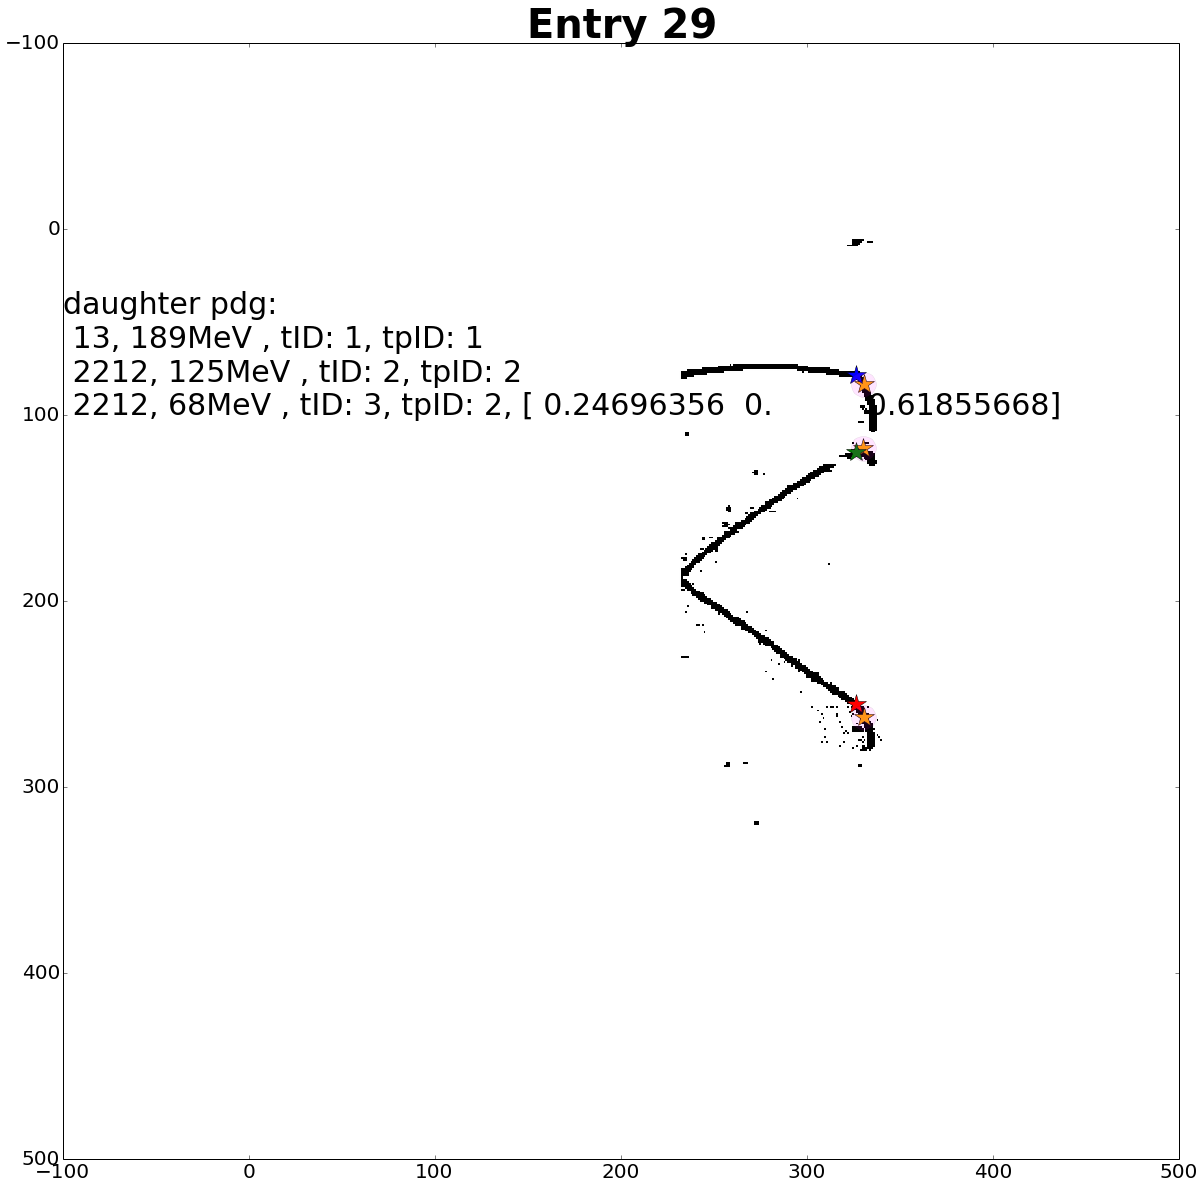

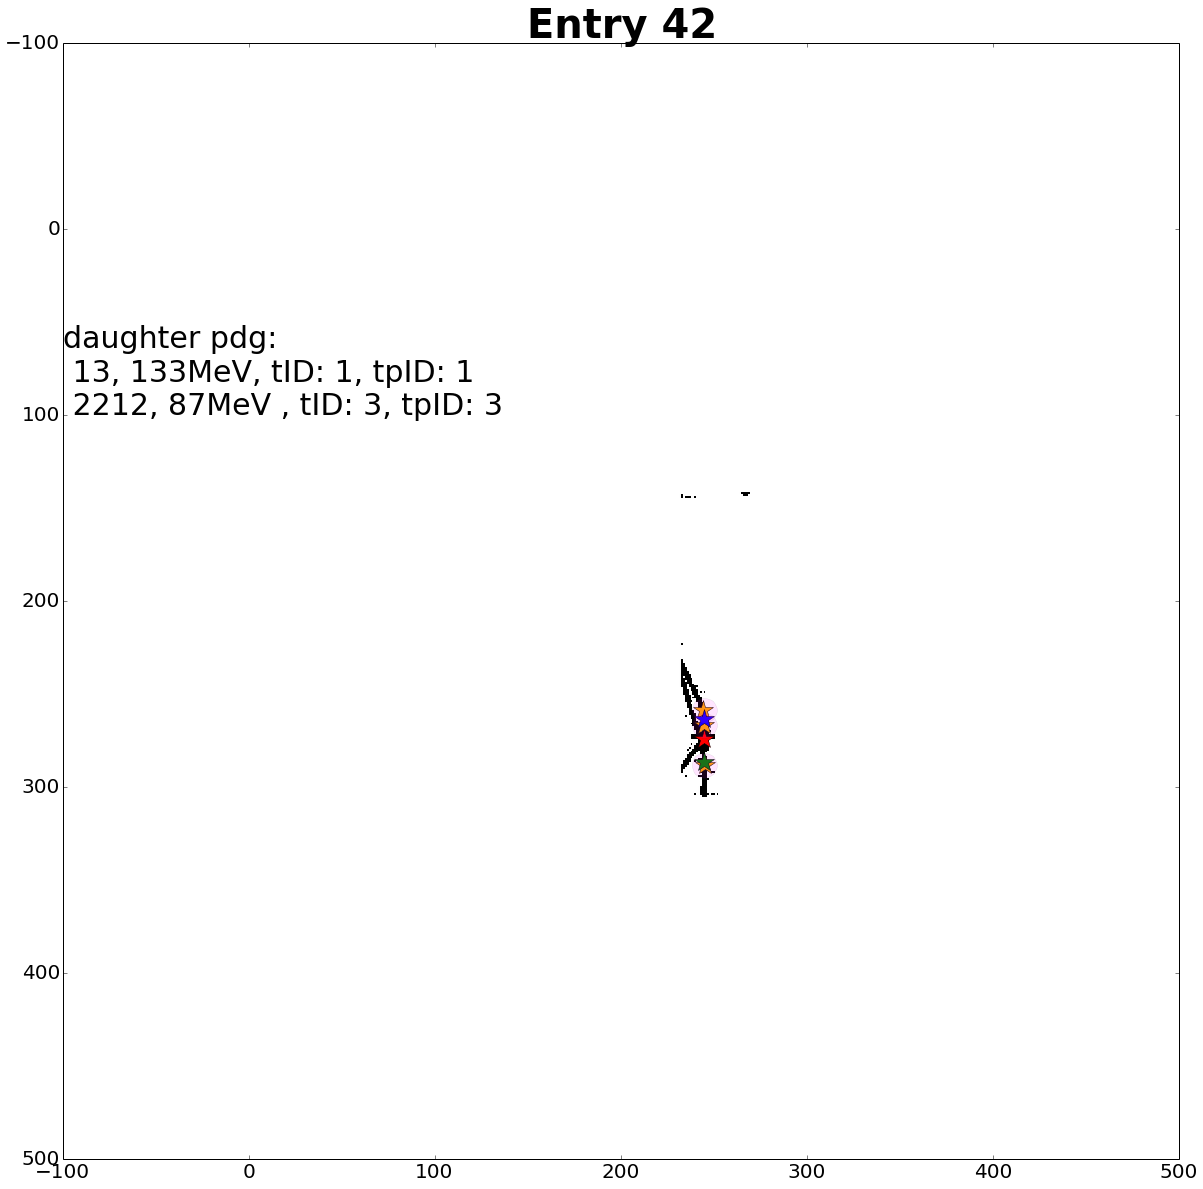

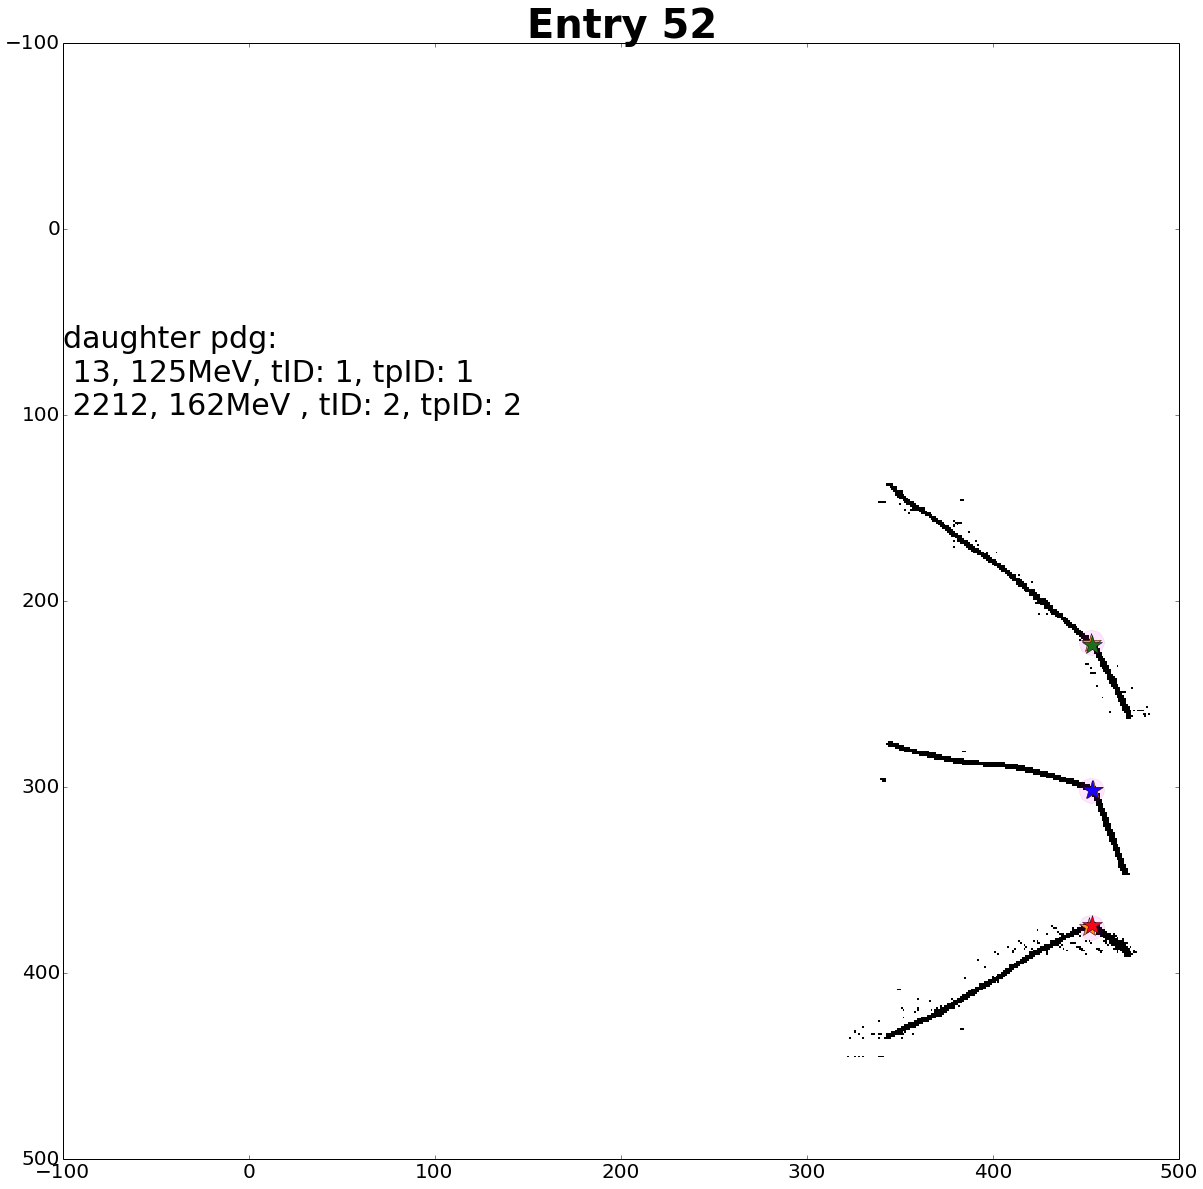

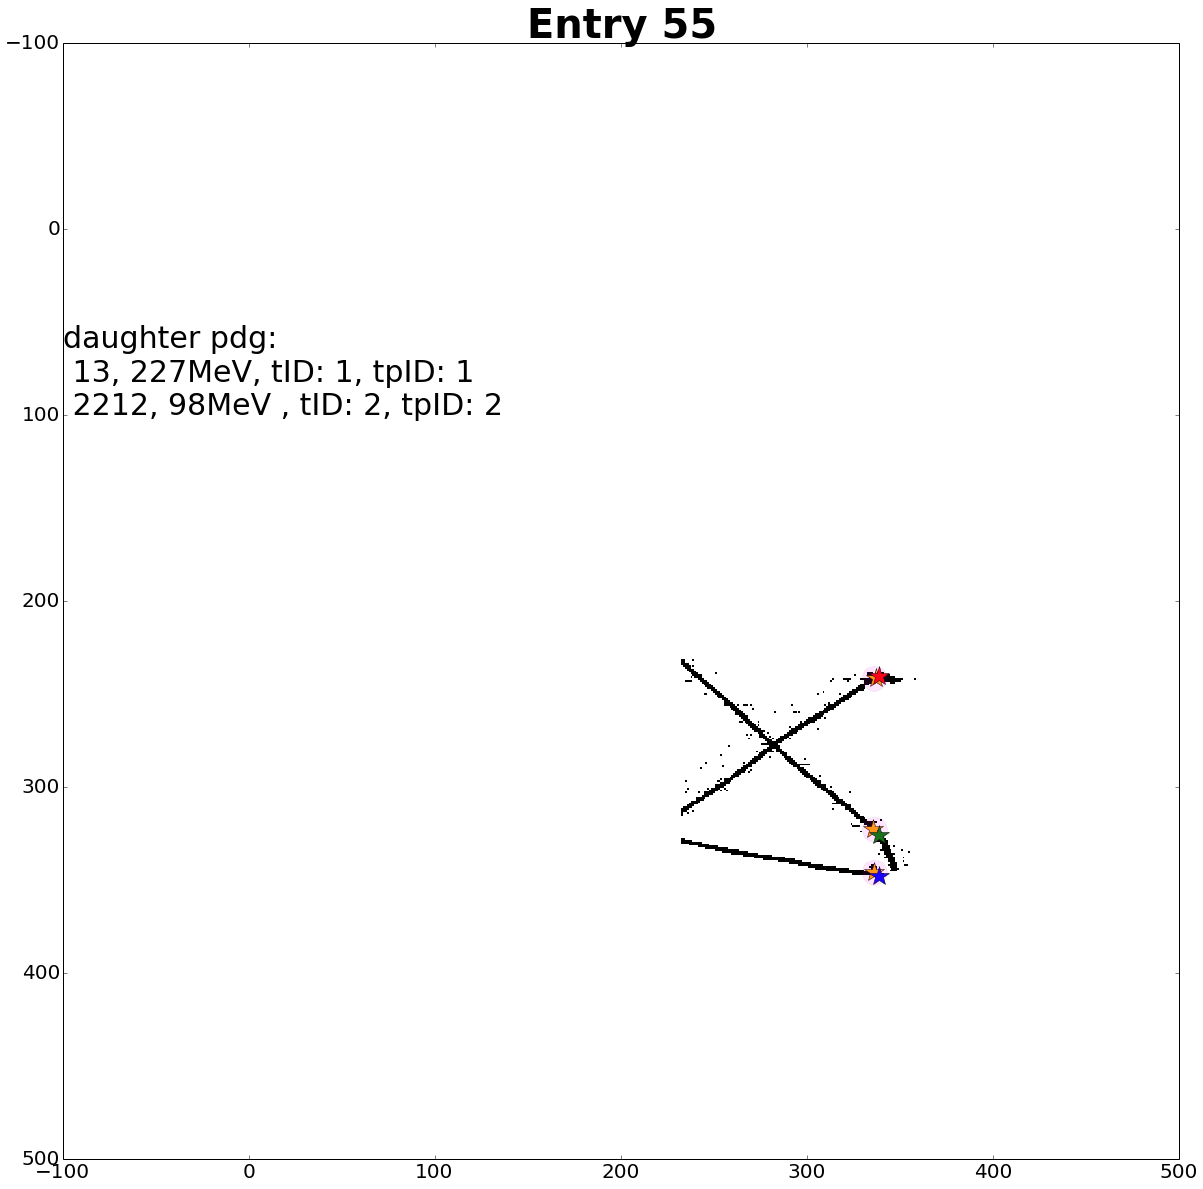

KeyError: 64

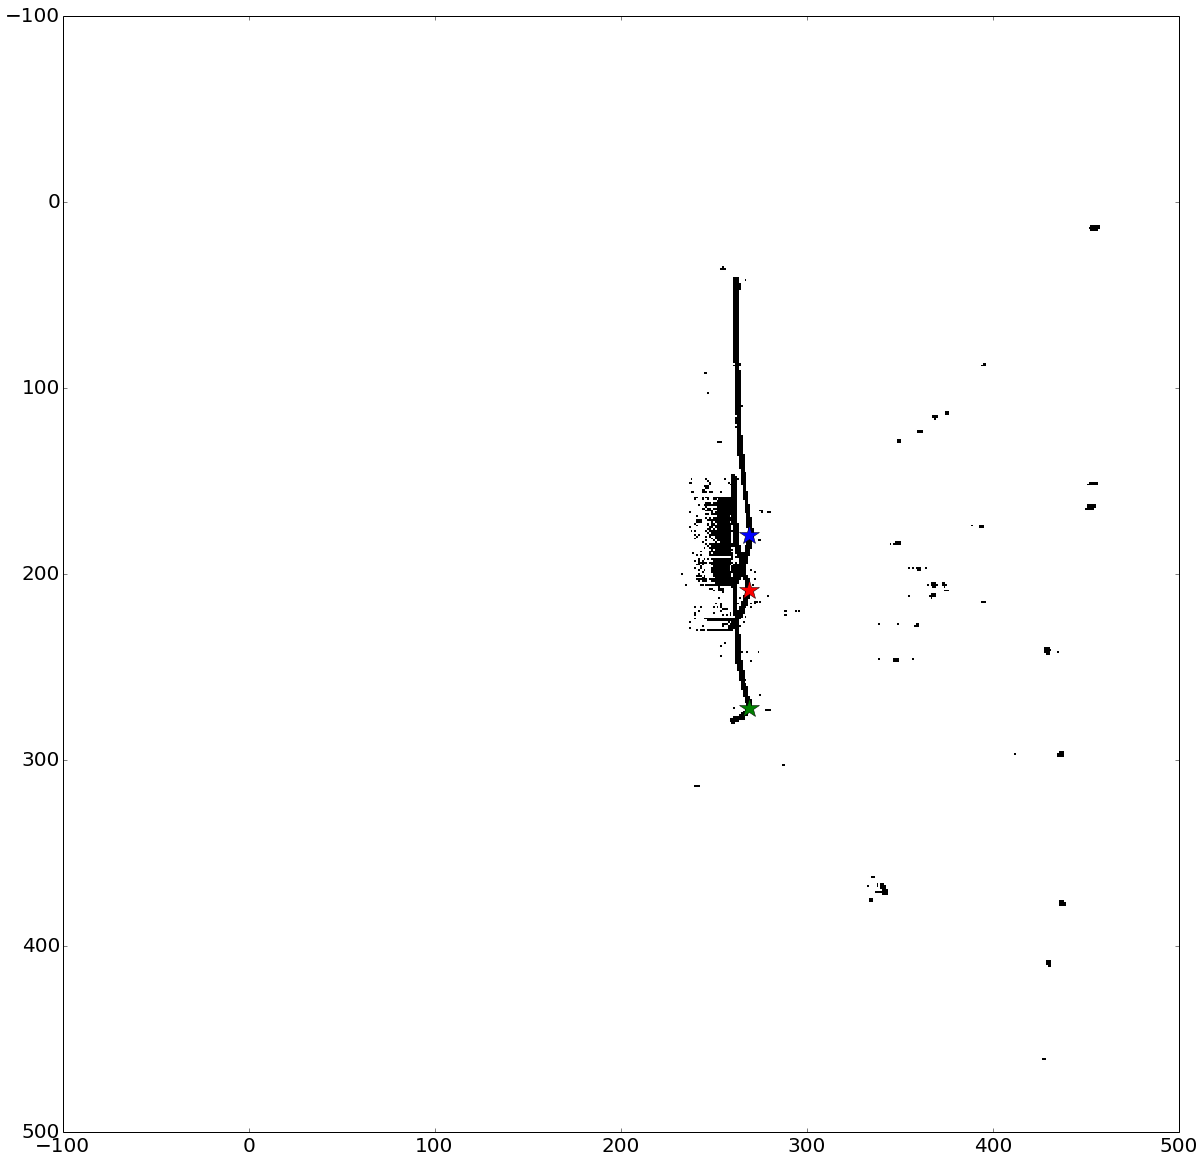

In [91]:
for ik,entry in enumerate(mclist):
    iom.read_entry(entry)
    larbysimg.process(iom)
    mgr=larbysimg.Manager()
    
    img_v = []

    fig,ax=plt.subplots(figsize=(20,20))
    maxx=0;minx=9999
    maxy=0;miny=9999
    plane=0

    caca_img=np.zeros((485, 485))
    sel_df=reco_df.iloc[entry]
    
    for mat in mgr.InputImages():

        img_v.append(pygeo.image(mat))
        shape_img=np.where(img_v[plane]>1.5,1.0,0.0).astype(np.uint8)

        plane+=1

        nz_pixels=np.where(shape_img>0.0)
        
        maxx=np.maximum(maxx,np.max(nz_pixels[1])+100)
        minx=np.minimum(minx,np.min(nz_pixels[1])-100)

        maxy=np.maximum(maxy,np.max(nz_pixels[0])+100)
        miny=np.minimum(miny,np.min(nz_pixels[0])-100)

        caca_img+=shape_img

    caca_img=np.where(caca_img>0,1.0,0.0)

    plt.imshow(caca_img,cmap='Greys',interpolation='none')
    for cv_x_v,cv_y_v in zip(sel_df.circle_vtx_x_vv,
                             sel_df.circle_vtx_y_vv):

        for x,y in zip(cv_x_v,cv_y_v):
            plt.plot(x,y,'*',color='orange',markersize=20)
        
    w_v=mc_df.iloc[entry].vtx2d_w
    t_v=mc_df.iloc[entry].vtx2d_t
    ic=-1
    colors=['red','green','blue']
           
    for w,t in zip(w_v,t_v):
            ic+=1
            plt.plot(t,w,'*',color=colors[ic],markersize=20)
    
    for vtx2_x_v,vtx2_y_v in zip(sel_df.vtx2d_x_vv,
                                 sel_df.vtx2d_y_vv):

        for x,y in zip(vtx2_x_v,vtx2_y_v):
            plt.plot(x,y,'o',color='magenta',markersize=25,alpha=0.1)
    

    if mc_df.iloc[entry].daughterPdg_v.size ==2 :
        plt.text(-100,100,"daughter pdg:\n %i, %dMeV, tID: %i, tpID: %i  \n %i, %dMeV , tID: %i, tpID: %i, %s"%
                 (mc_df.iloc[entry].daughterPdg_v[0],
                  mc_df.iloc[entry].daughterEnergyDep_v[0],
                  mc_df.iloc[entry].daughterTrackid_v[0],
                  mc_df.iloc[entry].daughterParentTrackid_v[0],
                  mc_df.iloc[entry].daughterPdg_v[1],
                  mc_df.iloc[entry].daughterEnergyDep_v[1],
                  mc_df.iloc[entry].daughterTrackid_v[1],
                  mc_df.iloc[entry].daughterParentTrackid_v[1],
                  vic_df.ix[entry].num_pixel_frac_vv[mc_idx_c[ik]]
                 ),fontsize = 30)
    if mc_df.iloc[entry].daughterPdg_v.size ==3 :
        plt.text(-100,100,"daughter pdg:\n %i, %dMeV , tID: %i, tpID: %i\n %i, %dMeV , tID: %i, tpID: %i\n %i, %dMeV , tID: %i, tpID: %i, %s "%(
                mc_df.iloc[entry].daughterPdg_v[0],
                mc_df.iloc[entry].daughterEnergyDep_v[0],
                mc_df.iloc[entry].daughterTrackid_v[0],
                mc_df.iloc[entry].daughterParentTrackid_v[0],
                mc_df.iloc[entry].daughterPdg_v[1],
                mc_df.iloc[entry].daughterEnergyDep_v[1], 
                mc_df.iloc[entry].daughterTrackid_v[1],
                mc_df.iloc[entry].daughterParentTrackid_v[1],
                mc_df.iloc[entry].daughterPdg_v[2],
                mc_df.iloc[entry].daughterEnergyDep_v[2],
                mc_df.iloc[entry].daughterTrackid_v[2],
                mc_df.iloc[entry].daughterParentTrackid_v[2],
                vic_df.ix[entry].num_pixel_frac_vv[mc_idx_c[ik]]
            ),fontsize = 30)

    ax.set_title("Entry {}".format(entry),fontweight='bold',fontsize=40)
    #plt.savefig("reco_%04d.png"%entry)
    #break
    plt.show()